**Name: Amir Hossein Haji Mohammad Rezaei**

**Student Number: 99109252**




# Neural-Network with Numpy

In this notebook, you are going to write and implement all the components required to create and train a two-layered neural network using NumPy.

## Imports & Seeding:

Importing some common libraries

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
np.random.seed(42)
%matplotlib inline

## Preparing the data

You'll train and evaluate your model on [Fashion MNIST](https://en.wikipedia.org/wiki/Fashion_MNIST) dataset. In this section, you'll download Fashion MNIST and split it into training and testing datasets.

In [ ]:
from sklearn.datasets import fetch_openml

# Using `fetch_openml`, download `Fashion-MNIST`
# and save the training data and labels in `X` and `y` respectively.
#############################
# Your code goes here (5 points)
dataset = fetch_openml(name = 'Fashion-MNIST')

X = dataset['data']
y = dataset['target']
#############################

# Normalization:
X = ((X / 255.) - .5) * 2

print(X.shape, y.shape)

(70000, 784) (70000,)


In [ ]:
from sklearn.model_selection import train_test_split

# Using `train_test_split`, split your data into two sets.
# Set the test_size to 10000

#############################
# Your code goes here (6 points)

x_train, x_test, y_train, y_test = train_test_split(X, y, test_size = 10000)
#############################

print(x_train.shape, y_train.shape, x_test.shape, y_test.shape)

(60000, 784) (60000,) (10000, 784) (10000,)


## Prepare training & validation sets

We'll use only 3 classes from Fashion MNIST: Trouser, T-shirt, and Sneaker classes.

The class labels for T-shirt, Trouser, and Sneaker are 0, 1, and 7 respectively.

In this part, you'll limit the testing and training sets to only these three classes.

In [ ]:
# Modify `y_train` and `x_train`.
# Only keep the 3 classes mentioned above.
#############################
# Your code goes here (4 points)

selected = (y_train == '0') | (y_train == '1')  | (y_train == '7')

x_train = x_train[selected]
y_train = y_train[selected]

y_train[y_train == '7'] = '2'

x_train = x_train.to_numpy()
y_train = y_train.to_numpy().astype(np.int32)
#############################

print(x_train.shape, y_train.shape)

(18022, 784) (18022,)


In [ ]:
# Modify `y_test` and `x_test`.
# Only keep the 3 classes mentioned above.
#############################
# Your code goes here (4 points)

selected = (y_test == '0') | (y_test == '1')  | (y_test == '7')

x_test = x_test[selected]
y_test = y_test[selected]

y_test[y_test == '7'] = '2'

x_test = x_test.to_numpy()
y_test = y_test.to_numpy().astype(np.int32)
#############################

print(x_test.shape, y_test.shape)

(2978, 784) (2978,)


## Linear & Activation Functions

In this part, you'll implement the forward and backward process for the following components:
- Softmax Layer
- Linear Layer
- ReLU Layer
- Sigmoid Layer

### The `Softmax` Layer

In [ ]:
def logsumexp(array, axis=1):
    """
    calculate log(sum(exp(array))) using np.logaddexp

    Args:
        array : input array
        axis : reduce axis, 1 means columns and 0 means rows
    """
    assert len(array) >= 2
    ans = None
    if axis == 0:
        for i in range(array.shape[0] - 1):
            if i == 0:
                ans = np.logaddexp(array[0, :], array[1, :])
            else:
                ans = np.logaddexp(ans, array[i + 1, :])

    else:
        for i in range(array.shape[1] - 1):
            if i == 0:
                ans = np.logaddexp(array[:, 0], array[:, 1])
            else:
                ans = np.logaddexp(ans, array[:, i + 1])

    return ans


# Implemented LogSoftmax for having simple computation of backward gradients
class LogSoftMaxLayer(object):
    def __init__(self):
        self.inp = None
        self.output = None

    def forward(self, x):
        # Write the forward pass for softmax.
        # Save the values required for the backward pass.
        #############################
        # Your code goes here (4 points)

        # Shift the input by its maximum value to prevent overflow of values in output
        shifted = x - np.max(x, axis=1, keepdims=True)
        sums = logsumexp(x)
        y = (x.T - sums).T
        self.output = y
        self.inp = shifted
        #############################
        return self.output

    def backward(self, up_grad):
        # Write the backward pass for softmax.
        #############################
        # Your code goes here (4 points)

        down_grad = None
        x = self.inp
        m, n = x.shape

        result = []
        for i in range(m):
            for j in range(n):
                sums = 0
                row = np.sum(np.exp(x[i, :]))
                for k in range(n):
                    if k == j:
                        sums += up_grad[i, k] * (1 - (np.exp(x[i, j])/row))
                    else:
                        sums += up_grad[i, k] * - (np.exp(x[i, j])/row)
                result.append(sums)

        down_grad = np.array(result).reshape(x.shape)
        #############################
        return down_grad

    def step(self, optimizer):
      pass

### The `Linear` Layer

In [ ]:
class Linear:
    def __init__(self, in_dim, out_dim):
        # Initialize the layer's weights and biases
        #############################
        # Your code goes here (2 points)
        self.in_dim = in_dim
        self.out_dim = out_dim
        self.w = np.random.randn(in_dim, out_dim) * np.sqrt(6 / out_dim)
        self.b = np.zeros(out_dim)
        #############################
        self.inp = None
        self.dw = None
        self.db = None

    def forward(self, inp):
        # Compute linear layer's output.
        # Save the value(s) required for the backward phase.
        #############################
        # Your code goes here (4 points)
        self.inp = inp
        z = np.dot(inp, self.w) + self.b
        #############################

        return z

    def backward(self, up_grad):
        # Calculate the gradient with respect to the weights
        # and biases and save the results.
        #############################
        # Your code goes here (6 points)

        down_grad = np.dot(up_grad, self.w.T)
        self.dw = np.dot(self.inp.T, up_grad)
        self.db = np.sum(up_grad, axis = 0)
        #############################
        return down_grad

    def step(self, optimizer):
      # Update the layer's weights and biases
      # Update previous_w_update and previous_b_update accordingly
      #############################
      # Your code goes here (5 points)
      self.w = optimizer.get_next_update(self.w, self.dw)
      self.b = optimizer.get_next_update(self.b, self.db)
      #############################

### The `ReLU` Layer

In [ ]:
class RelU:
    def __init__(self):
        self.inp = None

    def forward(self, inp):
        # Write the forward pass for ReLU.
        # Save the value(s) required for the backward pass.
        #############################
        # Your code goes here (4 points)
        self.inp = inp
        output = (np.abs(inp) + inp) / 2
        #############################
        return output

    def backward(self, up_grad):
        #############################
        # Your code goes here (4 points)
        filter = (self.inp > 0)
        down_grad = filter * up_grad
        #############################
        return down_grad

    def step(self, optimizer):
      pass

### The `sigmoid` Layer

In [ ]:
class Sigmoid:
    def forward(self, inp):
        #############################
        # Your code goes here (4 points)
        self.out = 1 / (1 + np.exp(-inp))
        #############################
        return self.out

    def backward(self, up_grad):
        #############################
        # Your code goes here (4 points)
        down_grad = self.out * (1 - self.out) * up_grad
        #############################
        return down_grad

    def step(self, optimizer):
      pass

## `Loss` function :

For this task we are going to use the [Cross-Entropy Loss](https://en.wikipedia.org/wiki/Cross_entropy).

In [ ]:
class CELoss():
    def __init__(self):
      pass

    def forward(self, pred, target):

        self.log_yhat = pred
        self.y = target
        m = self.y.shape[0]
        # Commpute and return the loss
        #############################
        # Your code goes here (8 points)
        selected = self.log_yhat[range(m), self.y]

        loss = -np.sum(selected)
        loss /= m

        return loss
        #############################


    def backward(self):
        # Derivative of loss_fn with respect to a the predicted label.
        # Use `self.y` and `self.yhat` to compute and return `grad`.
        #############################
        # Your code goes here (6 points)
        grad = None
        m, n = self.log_yhat.shape

        result = []
        for i in range(m):
            for j in range(n):
                if j != self.y[i]:
                    result.append(0)
                else:
                    result.append(-1/m)

        grad = np.array(result).reshape(m, n)
        #############################
        return grad

## Optimizer

In this section, you'll implement an optimizer classes


In [ ]:
class GradientDescent(object):
    def __init__(self, lr):
        self.lr = lr

    def get_next_update(self, x, dx):
        # Compute the new value for 'x' and return the result
        #############################
        # Your code goes here (2 points)
        result = x - self.lr * dx
        return result
        #############################

## The Model
Now you'll write the base class for a multi-layer perceptron network.

In [ ]:
class MLP:
    def __init__(self, layers, loss_fn, optimizer):
        self.layers = layers
        self.losses  = []
        self.loss_fn = loss_fn
        self.optimizer = optimizer

    def forward(self, inp):
        # Pass `inp` to all the layers sequentially
        # and return the result.
        #############################
        # Your code goes here (4 points)
        x = inp
        for l in self.layers:
          x = l.forward(x)
        return x
        #############################

    def loss(self, pred, label):
        loss = self.loss_fn.forward(pred, label)
        self.losses.append(loss)
        return loss

    def backward(self):
        # Start with loss function's gradient and
        # do the backward pass on all the layers.
        #############################
        # Your code goes here (5 points)
        up_stream = self.loss_fn.backward()

        for i in range(len(self.layers) - 1, -1, -1):
          up_stream = self.layers[i].backward(up_stream)
        #############################

    def update(self):
        for layer in self.layers:
          layer.step(self.optimizer)

The following cell encodes training labels into a one-hot representation with 3 classes.

In [ ]:
def onehot_enc(y, num_labels):
    ary = np.zeros((y.shape[0], num_labels))
    for i, val in enumerate(y):
        ary[i, val] = 1
    return ary

# y_train = onehot_enc(y_train, 3)
# There is no need to use one-hot encoding in this implementation

In [ ]:
def train(model, epochs, x, y):
    for n in range(epochs):
      # First do the forward pass. Next, compute the loss.
      # Then do the backward pass and finally, update the parameters.
      #############################
      # Your code goes here (4 points)
      pred = model.forward(x)
      loss = model.loss(pred, y)
      model.backward()
      model.update()
      #############################
      print(f"Loss at {n}: {loss:.3f}")

In [ ]:
# Instantiate the `MLP` with the following structure:
#     Linear with 50 units --> ReLU --> Linear with 50 units --> ReLU --> Linear with 3 units --> Sigmoid --> Softmax
# Use GradientDescent as the optimizer, set the learning rate to 0.001, and use CELoss as the loss function.
#############################
# Your code goes here (4 points)

layers = [Linear(784, 50), RelU(), Linear(50, 50), RelU(), Linear(50, 3), Sigmoid(), LogSoftMaxLayer()]
optimizer = GradientDescent(lr = 0.01)
loss_fn = CELoss()

nn = MLP(layers, loss_fn, optimizer)
#############################

epochs = 50

# Train the network using only `x_train` and `y_train` (no validation)
train(nn, epochs, x_train, y_train)

Loss at 0: 1.030
Loss at 1: 1.024
Loss at 2: 1.018
Loss at 3: 1.012
Loss at 4: 1.004
Loss at 5: 0.996
Loss at 6: 0.987
Loss at 7: 0.978
Loss at 8: 0.969
Loss at 9: 0.959
Loss at 10: 0.950
Loss at 11: 0.941
Loss at 12: 0.932
Loss at 13: 0.924
Loss at 14: 0.914
Loss at 15: 0.906
Loss at 16: 0.899
Loss at 17: 0.893
Loss at 18: 0.886
Loss at 19: 0.879
Loss at 20: 0.874
Loss at 21: 0.868
Loss at 22: 0.863
Loss at 23: 0.858
Loss at 24: 0.854
Loss at 25: 0.850
Loss at 26: 0.847
Loss at 27: 0.843
Loss at 28: 0.840
Loss at 29: 0.837
Loss at 30: 0.834
Loss at 31: 0.831
Loss at 32: 0.828
Loss at 33: 0.824
Loss at 34: 0.821
Loss at 35: 0.818
Loss at 36: 0.815
Loss at 37: 0.812
Loss at 38: 0.809
Loss at 39: 0.806
Loss at 40: 0.804
Loss at 41: 0.802
Loss at 42: 0.799
Loss at 43: 0.797
Loss at 44: 0.795
Loss at 45: 0.793
Loss at 46: 0.791
Loss at 47: 0.789
Loss at 48: 0.788
Loss at 49: 0.786


Let's plot the loss value for each iteration

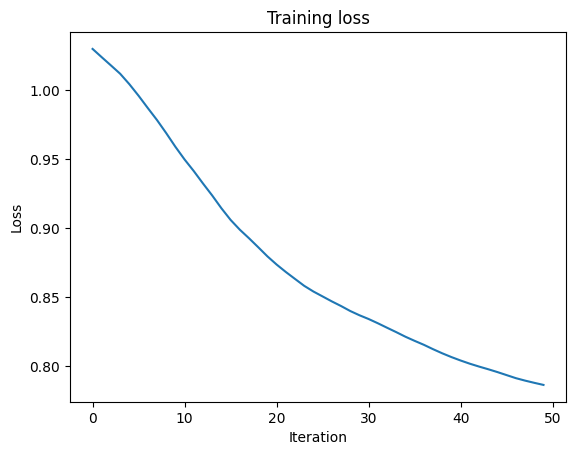

In [ ]:
plt.plot(nn.losses)
plt.title("Training loss")
plt.xlabel("Iteration")
plt.ylabel("Loss");

**Let's also check our model's performance using the `accuracy` metric on the `testing` dataset**

In [ ]:
# Compute the accuracy on the testing set
#############################
# Your code goes here (7 points)

pred = nn.forward(x_test)
pred = np.argmax(pred, axis = 1)

acc = np.sum(pred == y_test) / pred.shape[0]
#############################

print(acc)

0.8294157152451309
